In [391]:
import numpy as np
from numpy.linalg import inv as inv
from scipy.linalg import solve_continuous_are
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt
import cvxpy as cp
import time

DIMENSION = 1

In [453]:
# Computer K and P_t-1 for standard LQR controller
def lqr(A, B, Q, R, P):
    K = -1 * inv(B.T @ P @ B + R) @ B.T @ P @ A
    Ptm1 = A.T @ P @ A + (B.T @ P @ A).T @ K + Q
    return K, Ptm1

# Compute terms when we are trying to be robust to estimation error
def dist_lqr(A, B, Q, R, S, P, lam, d_max):
    I = np.eye(DIMENSION)
    G = - inv(Q + A.T@P@A - lam*S) 
    M = G@A.T@P
    Qp =  M.T@Q@M + (I + A@M).T @ P @ (I + A@M) - lam * M.T@S@M
    Qpp = M.T@Q@G + (I + A@M).T @ P @ (A@G) - lam*M.T @ (S@M - I)

    # u = K xhat    
    K = - lam * inv(B.T@Qp@B + R) @ B.T@Qpp@S
    
    # x = L xhat
    L = - inv(Q + A.T@P@A - lam*S) @ (A.T@P@B@K + lam*S)
    
    # xhat.T Pt xhat
    Ptm1 = Q + K.T@R@K + (A+B@K).T@P@(A+B@K) - lam * ((L - I).T@S@(L - I) - d_max)
    return K, L, Ptm1


def get_opt_dist(x, A, B, Q, R, S, P, K):
    # TODO: Compute minimal lambda with SDP
    lam = 1
    
    # Vd = min_x   xQx + uQu + (Ax+Bu)P(Ax+Bu) - lam*dSd - lam*d_max
    G = Q + K.T@R@K + (A + B@K).T @ P @ (A + B@K)    
    dist = -1 * inv(G - lam * S) @ G
    
    return dist@x

def get_opt_dist_cvxpy(x, A, B, Q, R, S, P, K):
    # TODO: Switch to SDP with S-lemma
    G = Q + K.T@R@K + (A + B@K).T @ P @ (A + B@K)  
    
    d = cp.Variable(x.shape)
    opt = cp.Maximize((x+d).T@G@(x+d))  # doesn't follow dcp rules
    const = [d.T@S@d - 1 <= 0]
    prob = cp.Problem(opt, const)
    prob.solve()
    d = d.value
    print(d)
    return d

def get_opt_dist_SDP(x, A, B, Q, R, S, P, K, d_max):
    if d_max == 0:
        return 0
    
    # G = Q + K.T@R@K + (A + B@K).T @ P @ (A + B@K)  
    
    N = K.T@R@K + K.T@B.T@P@B@K
    M = K.T@R@K + (A+B@K).T@P@B@K
    L = Q + K.T@R@K.T + (A+B@K).T@P@(A+B@K)
    
    q = 2*M.T@x
    r = x.T@L@x
    # Q1 = np.block([[G,q],[q.T,r]])
    Q1 = np.block([[N, M],[M.T, r]])
    Q2 = np.block([[S,np.zeros(q.shape)],[np.zeros(q.T.shape),-d_max]])
    # T = np.zeros(Q1.shape)
    t = cp.Variable()
    l = cp.Variable()
    T = np.block([[np.zeros(S.shape),np.zeros(q.shape)],[np.zeros(q.T.shape),1]])
    
    
    opt = cp.Minimize(t)
    c1 = l >= 0
    c2 = Q1 << l*Q2 + t*T
    prob = cp.Problem(opt, [c1, c2])
    prob.solve()
    
    t = t.value
    lam = l.value
    dist = -1 * inv(K.T@R@K + K.T@B.T@P@B@K - lam*S) @ (K.T@R@K + K.T@B.T@P@(A+B@K)) @ x
    print(inv(K.T@R@K + K.T@B.T@P@B@K - lam*S), (K.T@R@K + K.T@B.T@P@(A+B@K)))
    print(K, P, A, B)
    print(K.T@B.T@P@(A+B@K))
    return 0
#     dist = -1 * inv(G - lam * S) @ G @ x
    
#     d1 = (-2*G@x + np.sqrt((2*G@x)**2 - 4*(G@x**2 - t)) )/2
#     d2 = (-2*G@x - np.sqrt((2*G@x)**2 - 4*(G@x**2 - t)) )/2
    print(d1, d2, dist)
    
    return d1
    print(x)
    print(dist)
    
    print("Hi")
    print((x-dist).T@G@(x-dist))
    print(t)
    

#     d = cp.Variable(x.shape)
#     opt = cp.Minimize(x.T@G@x + 2*x.T@G@d + d.T@G@ - t)
#     c1 = d >= 0
#     prob = cp.Problem(opt, [c1])
#     prob.solve()
#     print(prob)
#     print(prob.value)
    

#     d = cp.Variable(x.shape)
#     opt = cp.Maximize((x+d).T@G@(x+d))  # doesn't follow dcp rules
#     const = [d.T@S@d - 1 <= 0]
#     prob.solve()
#     d = d.value
#     print(d)
    return 0


In [454]:
# Losses
# J_lqr = lambda x,u,Q,R: (x.T@Q@x + u.T @R@u)[0][0]
J_lqr = lambda x,u,A,B,Q,R,P: (x.T@Q@x + u.T@R@u + (A@x + B@u).T@P@(A@x + B@u))[0][0]

# Standard LQR with disturbance
def run_lqr(x, A, B, Q, R, S, n_steps=5, d_max=1):
    '''
    x: starting position
    S: paramterization of ellipse, S is PD
    d_max: disturbance within a ball of radius d_max 
    vd_lam: lagrange multiplier for Vd constraint equation
    '''

    # Compute P_t for each t assuming P_T = Q
    P = [Q]
    opt_dist = [(P[0].shape)]
    for i in range(n_steps-1):
        K, Ptm1 = lqr(A, B, Q, R, P[-1])
        P.append(Ptm1)
    # flip around so P[t] = P_t
    P = P[::-1]  
    
    cost = []
    noise = 0
    for i in range(n_steps):
        K, Ptm1 = lqr(A, B, Q, R, P[i])
        
        # Optimal disturbance, not working
        #print(i)
        #time.sleep(0.1)
        noise = get_opt_dist_SDP(x, A, B, Q, R, S, P[i], K, d_max)
        print(noise)
        
        # Random disturbance within ball radius d_max
        # noise = 2*d_max*(np.random.random(x.shape) - 0.5)

        xhat = x + noise
        u = K@xhat
        cost.append(J_lqr(x,u,A,B,Q,R,P[i]))
        
        # Update location
        x = A@x + B@u

    return cost
    

# def run_dist_lqr(x, A, B, Q, R, S, n_steps=5, d_max=1):
#     '''
#     Same thing as previous function but compute control trying to compensate for any potential disturbance
#     '''
#     # TODO: Figure out how to compute this lambda
#     lam = 100
    
#     y = np.copy(x)
#     I = np.eye(DIMENSION)
#     P = [Q]
#     opt_dist = [np.zeros(P[0].shape), ]
#     for i in range(n_steps-1):
#         K, L, Ptm1 = dist_lqr(A, B, Q, R, S, P[-1], lam, d_max)
#         P.append(Ptm1)
        
#     P = P[::-1]
#     # need to sweet over lam1

#     cost = []
#     noise = 0
#     for i in range(n_steps):
#         K, L, Ptm1 = dist_lqr(A, B, Q, R, S, P[i], lam, d_max)

#         # Optimal disturbance, not working
#         # noise = get_opt_dist(x, A, B, Q, R, S, P[i], K)
        
#         # Random disturbance within ball radius d_max
#         noise = 2*d_max*(np.random.random(x.shape) - 0.5)
        
#         xhat = x + noise
#         cost.append(J_lqr(xhat, K@xhat,A,B,Q,R,P[i]))
        
#         x = L @ xhat
    
#     print(y)
    
#     return cost

In [458]:
Q = np.eye(DIMENSION)
R = np.eye(DIMENSION) 
A = np.array([[1]])
B = np.array([[1]])
#A = np.random.normal(0,1,(DIMENSION,DIMENSION))
# B = np.random.normal(0,1,(DIMENSION,DIMENSION))
S = np.eye(DIMENSION) 

0
0
[[1.45246706e+08]] [[1.11022302e-16]]
[[-0.6]] [[1.5]] [[1]] [[1]]
[[-0.36]]
0
[[2.34908297e+09]] [[0.]]
[[-0.5]] [[1.]] [[1]] [[1]]
[[-0.25]]
0
[[1]]


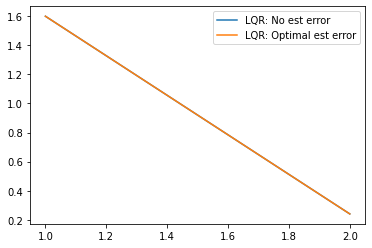

In [459]:
# Starting position, goal at [0,0]
# x = [[1],[1]]
x = [[1] for i in range(DIMENSION)]

n_steps = 2

# Maximum disturbance
d_max = 1

# Standard LQR, d_max = 0
no_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=0)

# Standard LQR with estimation error, d_max = d_max
yes_dist_y = run_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max)

# Our thing
rnd_dist_y_opt = run_dist_lqr(np.array(x), A, B, Q, R, S, n_steps=n_steps, d_max=d_max)

x = [i for i in range(1,n_steps+1)]


plt.figure()
plt.plot(x, no_dist_y, label="LQR: No est error")
plt.plot(x, yes_dist_y, label="LQR: Optimal est error")
# plt.plot(x, rnd_dist_y_opt, label="Our thing: Random disturbance")

plt.legend()
plt.show()

In [364]:
np.eye(1)

array([[1.]])